In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.dont_write_bytecode = True
import json
import time
from datetime import datetime
import single_node_profiles_cpp as snp
import profiler
import numpy as np
from optimizer import GreedyOptimizer
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
profs = snp.load_single_node_profiles(models=["inception", "tf-resnet-feats", "tf-kernel-svm", "tf-log-reg", "tf-kernel-svm-big"], single_node_profs_dir="../results_cpp_benchmarker/bare_metal_profs_no_contention/")

In [4]:
old_profs = snp.load_single_node_profiles(models=["inception", "tf-resnet-feats", "tf-kernel-svm", "tf-log-reg"])

In [5]:
profs.keys()

[u'inception',
 u'tf-resnet-feats',
 u'tf-kernel-svm',
 u'tf-kernel-svm-big',
 u'tf-log-reg']

In [6]:
dag = profiler.get_logical_pipeline("pipeline_one")
with open(os.path.abspath("../results_python_benchmarker/e2e_profs_new_metrics/incep_1-logreg_1-ksvm_1-resnet_1-180207_063416.json")) as f:
    sample_run = json.load(f)
print(dag.reference_node)
scale_factors = profiler.get_node_scale_factors(sample_run, dag.reference_node)
node_configs = profiler.get_node_configs_from_experiment(sample_run)
def which_stage(model_name):
    if model_name == "tf-kernel-svm" or model_name == "tf-log-reg":
        return "latency_stage"
    else:
        return "thru_stage"
node_profs = {name : profiler.NodeProfile(name, profs[name], which_stage(name)) for name, _ in node_configs.items()}

inception


In [12]:
old_resnet = profiler.NodeProfile("tf-resnet-feats", old_profs["tf-resnet-feats"], "thru_stage")
old_resnet_array = np.sort(old_resnet.profile[["mean_batch_size", "p99_latency", "thru_stage_mean_throughput_qps"]].values, axis=0)
old_resnet_array = old_resnet_array[np.argsort(old_resnet_array[:,0])]
print old_resnet_array

print ""

resnet = profiler.NodeProfile("tf-resnet-feats", profs["tf-resnet-feats"], "thru_stage")
resnet_array = np.sort(resnet.profile[["mean_batch_size", "p99_latency", "thru_stage_mean_throughput_qps"]].values, axis=0)
resnet_array = resnet_array[np.argsort(resnet_array[:,0])]
print resnet_array

[[1.0000000e+00 1.3254010e-01 1.0000000e+01]
 [2.0000000e+00 1.3424957e-01 1.9700000e+01]
 [4.0000000e+00 1.3839000e-01 3.8600000e+01]
 [8.0000000e+00 1.4921285e-01 7.6100000e+01]
 [1.2000000e+01 1.5238963e-01 1.0520000e+02]
 [1.6000000e+01 1.7264560e-01 1.2620000e+02]
 [2.4000000e+01 2.1201610e-01 1.6890000e+02]
 [3.2000000e+01 2.5663817e-01 1.9150000e+02]
 [4.2870000e+01 5.3025450e-01 2.0900000e+02]]

[[1.0000000e+00 1.0887625e-01 9.9000000e+00]
 [2.0000000e+00 1.1104000e-01 2.0400000e+01]
 [4.0000000e+00 1.2155254e-01 3.9900000e+01]
 [8.0000000e+00 1.4182200e-01 7.3600000e+01]
 [1.6000000e+01 1.5272976e-01 1.2670000e+02]
 [3.2000000e+01 2.7838175e-01 1.5160000e+02]]


In [13]:
resnet = profiler.NodeProfile("tf-resnet-feats", profs["tf-resnet-feats"], "thru_stage")
old_resnet = profiler.NodeProfile("tf-resnet-feats-old", old_profs["tf-resnet-feats"], "thru_stage")
inception = profiler.NodeProfile("inception", profs["inception"], "thru_stage")
old_inception = profiler.NodeProfile("inception-old", old_profs["inception"], "thru_stage")
ksvm = profiler.NodeProfile("tf-kernel-svm", profs["tf-kernel-svm"], "thru_stage")
old_ksvm = profiler.NodeProfile("tf-kernel-svm-old", old_profs["tf-kernel-svm"], "thru_stage")
logreg = profiler.NodeProfile("tf-log-reg", profs["tf-log-reg"], "thru_stage")
old_logreg = profiler.NodeProfile("tf-log-reg-old", old_profs["tf-log-reg"], "thru_stage")

In [14]:
def plot_two_profiles(profile1, profile2):
    batches, latency_stage, thru_stage, p99 = profile1.plot_profile(just_values=True)
    o_batches, o_latency_stage, o_thru_stage, o_p99 = profile2.plot_profile(just_values=True)
    plt.figure(figsize=(14,5))
    plt.suptitle("{} and {}".format(profile1.name, profile2.name))
    plt.subplot(1,2,1)
    plt.xlabel("batch size")
    plt.ylabel("mean throughput")
    plt.plot(batches, latency_stage, label="{} latency stage".format(profile1.name))
    plt.plot(batches, thru_stage, label="{} thru stage".format(profile1.name))
    plt.plot(o_batches, o_latency_stage, label="{} latency stage".format(profile2.name))
    plt.plot(o_batches, o_thru_stage, label="{} thru stage".format(profile2.name))
    plt.legend()
    plt.subplot(1,2,2)
    plt.xlabel("batch size")
    plt.ylabel("p99 latency (s)")
    plt.plot(batches, p99, label="{} p99 lat".format(profile1.name))
    plt.plot(o_batches, o_p99, label="{} p99 lat".format(profile2.name))
    plt.legend()

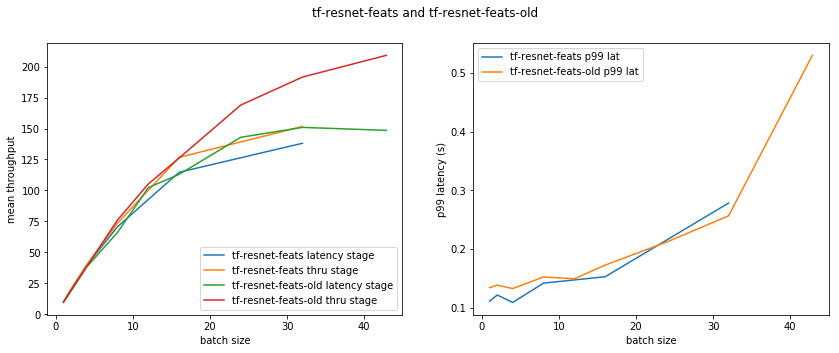

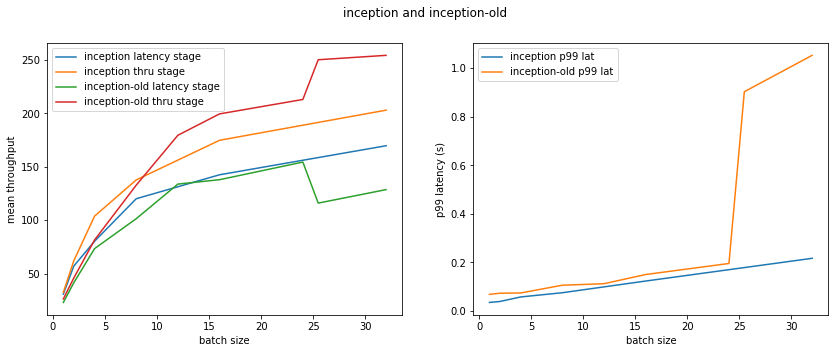

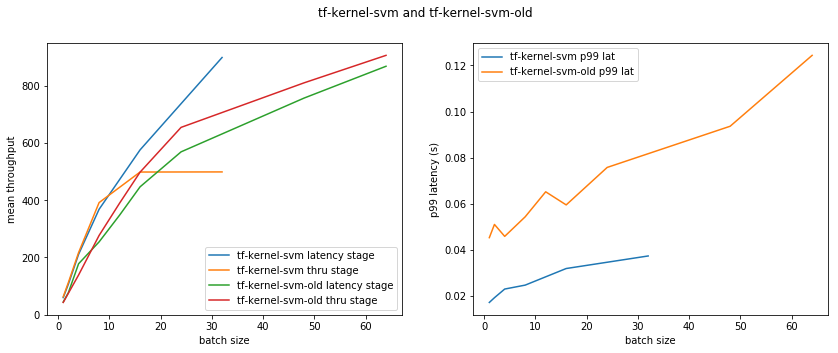

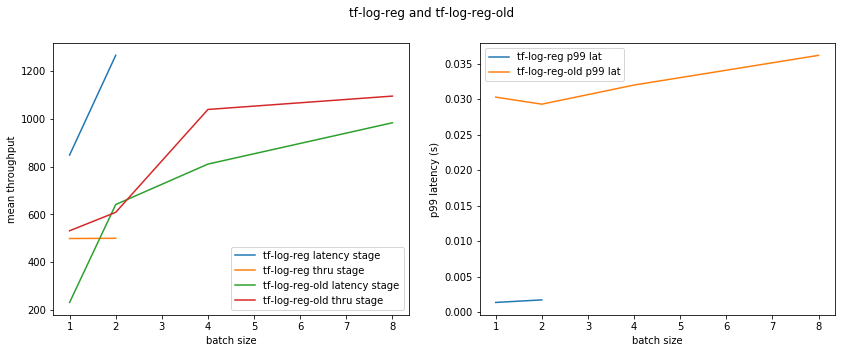

In [15]:
plot_two_profiles(resnet, old_resnet)
plot_two_profiles(inception, old_inception)
plot_two_profiles(ksvm, old_ksvm)
plot_two_profiles(logreg, old_logreg)

In [16]:
big_ksvm = profiler.NodeProfile("tf-kernel-svm-big", profs["tf-kernel-svm-big"], "thru_stage")

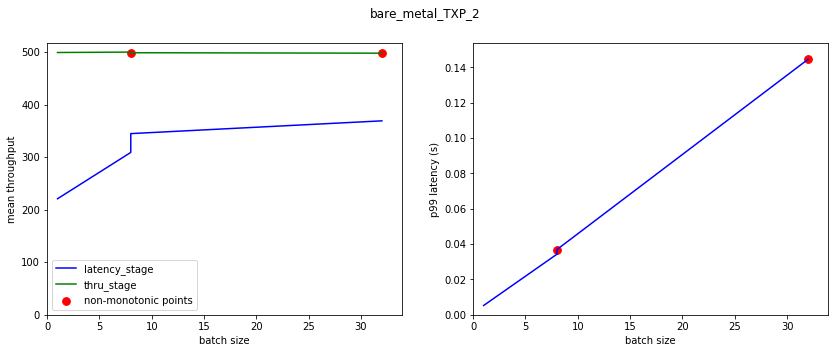

In [17]:
big_ksvm.plot_profile()

In [18]:
%config Application.log_level="INFO"
from optimizer import BruteForceOptimizer, GreedyOptimizer
opt = GreedyOptimizer(dag, scale_factors, node_profs)
cloud = "aws"
initial_config = {"tf-resnet-feats": profiler.NodeConfig(name="tf-resnet-feats",
                                                          num_cpus=1,
                                                          gpu_type="v100",
                                                          batch_size=1,
                                                          num_replicas=1,
                                                          cloud=cloud),
                  "inception": profiler.NodeConfig(name="inception",
                                                      num_cpus=1,
                                                      gpu_type="k80",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                  "tf-log-reg": profiler.NodeConfig(name="tf-log-reg",
                                                      num_cpus=1,
                                                      gpu_type="none",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                  "tf-kernel-svm": profiler.NodeConfig(name="tf-kernel-svm",
                                                      num_cpus=1,
                                                      gpu_type="none",
                                                      batch_size=1,
                                                      num_replicas=1,
                                                      cloud=cloud),
                 }
# 24 ms mean inter-arrival time
with open("../experiments/cached_arrival_processes/398.deltas", 'r') as f:
    deltas = np.array([float(l.strip()) for l in f]).flatten()
arrival_cached = np.cumsum(deltas)
opt.select_optimal_config(cloud, 0.35, 21, initial_config, arrival_cached)

INFO:optimizer:

Evaluating step batch_size
INFO:optimizer:
Old config: NodeConfig(tf-resnet-feats, 1, v100, 1, 1, aws)
New config: NodeConfig(tf-resnet-feats, 1, v100, 2.0, 1, aws)
INFO:optimizer:Doing network calc
INFO:optimizer:Response time: inf, T_s=0.11817702000000001, T_q=inf
INFO:optimizer:Node: tf-resnet-feats, Action: batch_size, bottleneck qpsd delta: 4.047022547697052
INFO:optimizer:Setting best action response time to inf
INFO:optimizer:

Evaluating step replication_factor
INFO:optimizer:
Old config: NodeConfig(tf-resnet-feats, 1, v100, 1, 1, aws)
New config: NodeConfig(tf-resnet-feats, 1, v100, 1, 2, aws)
INFO:optimizer:Doing network calc
INFO:optimizer:Response time: inf, T_s=0.11687844000000001, T_q=inf
INFO:optimizer:Node: tf-resnet-feats, Action: replication_factor, bottleneck qpsd delta: 0.0
INFO:optimizer:Upgrading bottleneck node tf-resnet-feats to NodeConfig(tf-resnet-feats, 1, v100, 2.0, 1, aws).
Increased QPSD by: 4.047022547697052.
New config: {'tf-resnet-feats

({'inception': NodeConfig(inception, 1, v100, 32.0, 3, aws),
  'tf-kernel-svm': NodeConfig(tf-kernel-svm, 1, none, 24.0, 1, aws),
  'tf-log-reg': NodeConfig(tf-log-reg, 1, none, 2.0, 1, aws),
  'tf-resnet-feats': NodeConfig(tf-resnet-feats, 1, v100, 24.0, 5, aws)},
 {'cost': 20.889,
  'latency': 0.16605398999999998,
  'throughput': 909.5999999999999},
 0.3403709438959971)

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [11]:
with open("arrival_deltas_ms", 'w') as f:
    for delta in np.diff(arrival_cached):
        f.write("{}\n".format(delta))

In [ ]:
import itertools
def brute_force_optimizer(dag, scale_factors, node_profs, cost_constraint, latency_constraint):
    """
        This doesn't loo
    """
    all_node_configs = [node_profs[node].enumerate_configs(max_replication_factor=3) for node in dag.nodes()]     
    all_pipeline_configs = itertools.product(*all_node_configs)
    num_valid_configs = 0
    best_config = None
    best_config_perf = None
    cur_index = 0
    for p_config in all_pipeline_configs:
        cur_index += 1
        if cur_index % 500 == 0:
            print("Processed {}".format(cur_index))
        cur_node_configs = {n.name: n for n in p_config}
        if not profiler.is_valid_pipeline_config(cur_node_configs):
            continue
        cur_config_perf = profiler.estimate_pipeline_performance_for_config(
            dag, scale_factors, cur_node_configs, node_profs)
        if cur_config_perf["latency"] <= latency_constraint and cur_config_perf["cost"] <= cost_constraint:
            if best_config is None:
                best_config = cur_node_configs
                best_config_perf = cur_config_perf
                print("Initializing config to {} ({})".format(best_config, best_config_perf))
            else:
                if cur_config_perf["throughput"] > best_config_perf["throughput"]:
                    best_config = cur_node_configs
                    best_config_perf = cur_config_perf
                    print("Updating config to {} ({})".format(best_config, best_config_perf))
        
    return best_config, best_config_perf

In [ ]:
start = datetime.now()
brute_force_optimizer(dag, scale_factors, node_profs, 7.0, 0.8)
end = datetime.now()
print("{}".format((end-start).total_seconds()))

In [ ]:
profiler.estimate_pipeline_performance_for_config(dag, scale_factors, node_configs, node_profs)

In [ ]:
groups = profs["alexnet"].groupby(["cloud","gpu_type","num_cpus_per_replica"])
groups

In [ ]:
for name, df in groups:
    print(name, df)